In [1]:
from __future__ import division
import math, sys
import numpy as np
import numpy.random as rd
import pandas as pd
from datetime import  datetime as dt
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import pystan
from pystan import StanModel

sns.set(style="whitegrid", palette="muted", color_codes=True)

In [2]:
# Pickleする
import cPickle as pickle
def unpickle(filename):
    with open(filename, 'rb') as fo:
        _dict = pickle.load(fo)
    return _dict

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)
        # pickle.Pickler(f, 2).dump(obj)

In [3]:
K = 10   # num of topics
M = 100  # num of documents
V = 144  # num of words

rd.seed(123)
alpha = [0.8] * K
beta  = [0.2] * V
theta = rd.dirichlet(alpha, size=M)
phi   = rd.dirichlet(beta,  size=K)

In [4]:
n_word_v = np.round(np.exp(rd.normal(5.0, 0.3, size=M))).astype(int)     # data1: low number of words per doc

In [5]:
# トピック生成
topics_doc = []
for m, n_word in enumerate(n_word_v):
    topics = rd.multinomial(1, theta[m], size=n_word)    
    topics_doc.append(map(lambda x: np.argmax(x), topics))

    # 単語生成
word_in_docs = []
for doc in topics_doc:
    words = [np.argmax(rd.multinomial(1, phi[topic], size=1)[0]) for topic in doc]
    word_in_docs.append(map(lambda x: x+1, words))

In [6]:
doc_nums = []
freq_list = []
flat_words = []
offset  = []
offset.append(0)
for doc_num, words in enumerate(word_in_docs):
    cnt = Counter(words)
    words = cnt.keys()
    freq = cnt.values()
    freq_list.extend(freq)
    flat_words.extend(words)
    doc_nums.extend([doc_num]*len(words))
    offset.append(offset[-1]+len(freq))
    
paired_offset = []
for i in range(len(offset)-1):
    paired_offset.append([offset[i]+1, offset[i+1]])
    
N = len(freq_list)

data ={
    "K": K,
    "M": M,
    "V": V,
    "N": N,
    "W": flat_words,
    "Freq": freq_list,
    "Offset": np.array(paired_offset),
    "Alpha": [1] * K,
    "Beta": [0.5]* V
}

In [7]:
# http://statmodeling.hatenablog.com/entry/topic-model-4 に掲載のStanコードより
stan = u"""
data {
   int<lower=2> K;                    # num topics
   int<lower=2> V;                    # num words
   int<lower=1> M;                    # num docs
   int<lower=1> N;                    # total word instances
   int<lower=1,upper=V> W[N];         # word n
   int<lower=1> Freq[N];              # frequency of word n
   int<lower=1,upper=N> Offset[M,2];  # range of word index per doc
   vector<lower=0>[K] Alpha;          # topic prior
   vector<lower=0>[V] Beta;           # word prior
}
parameters {
   simplex[K] theta[M];   # topic dist for doc m
   simplex[V] phi[K];     # word dist for topic k
}
model {
   # prior
   for (m in 1:M)
      theta[m] ~ dirichlet(Alpha);
   for (k in 1:K)
      phi[k] ~ dirichlet(Beta);

   # likelihood
   for (m in 1:M) {
      for (n in Offset[m,1]:Offset[m,2]) {
         real gamma[K];
         for (k in 1:K)
            gamma[k] <- log(theta[m,k]) + log(phi[k,W[n]]);
         increment_log_prob(Freq[n] * log_sum_exp(gamma));
      }
   }
}
"""

In [8]:
dt.now()

datetime.datetime(2016, 5, 6, 15, 33, 3, 220275)

In [9]:
%time stm = StanModel(model_code=stan.encode("utf-8"))

CPU times: user 1.98 s, sys: 212 ms, total: 2.2 s
Wall time: 59.8 s


In [10]:
n_itr = 1000
n_warmup = 100
chains = 1

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 52min 10s, sys: 232 ms, total: 52min 10s
Wall time: 52min 10s


In [11]:
to_pickle("stan_lda_fit.pkl",fit)
to_pickle("stan_lda_model.pkl",stm)

/mnt/workspace/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


In [12]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

print fit

Inference for Stan model: anon_model_c8bacdf06012b3629ae8d1fd42a810ab.
1 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=900.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0,0]    0.02  1.0e-3   0.02 6.2e-4 7.6e-3   0.02   0.03   0.06  300.0    1.0
theta[1,0]    0.23  3.4e-3   0.06   0.12   0.19   0.23   0.27   0.34  282.0    1.0
theta[2,0]    0.07  2.6e-3   0.04 2.6e-3   0.03   0.06   0.09   0.16  283.0    1.0
theta[3,0]     0.1  2.5e-3   0.04   0.03   0.07   0.09   0.13    0.2  300.0    1.0
theta[4,0]    0.16  3.3e-3   0.05   0.06   0.12   0.16    0.2   0.27  271.0    1.0
theta[5,0]    0.02 10.0e-4   0.02 5.9e-4 5.6e-3   0.01   0.02   0.07  300.0    1.0
theta[6,0]    0.08  3.0e-3   0.05 5.6e-3   0.04   0.07   0.11    0.2  300.0    1.0
theta[7,0]    0.17  3.4e-3   0.06   0.07   0.13   0.17   0.21   0.29  274.0    1.0
theta[8,0]    0.04  1.9e-3   0.03 1.8e-3   0.02   0.04   0.06   0.1

In [13]:
summary = fit.summary()
EAP_theta = summary["summary"][:1000,0].reshape(10,100)
EAP_phi = summary["summary"][1000:-1,0].reshape(144,10)

In [14]:
cos = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        x = EAP_phi[:,i]
        y = phi[j,:]
        cos[i,j] = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

param_order = []
for c in cos:
    print np.argmax(c), np.max(c)
    param_order.append(np.argmax(c))

1 0.935244774718
7 0.959680111895
5 0.959286177616
4 0.953526154971
0 0.94027301898
6 0.96531190331
8 0.933769615045
9 0.969027087283
2 0.970006556373
3 0.969940383761


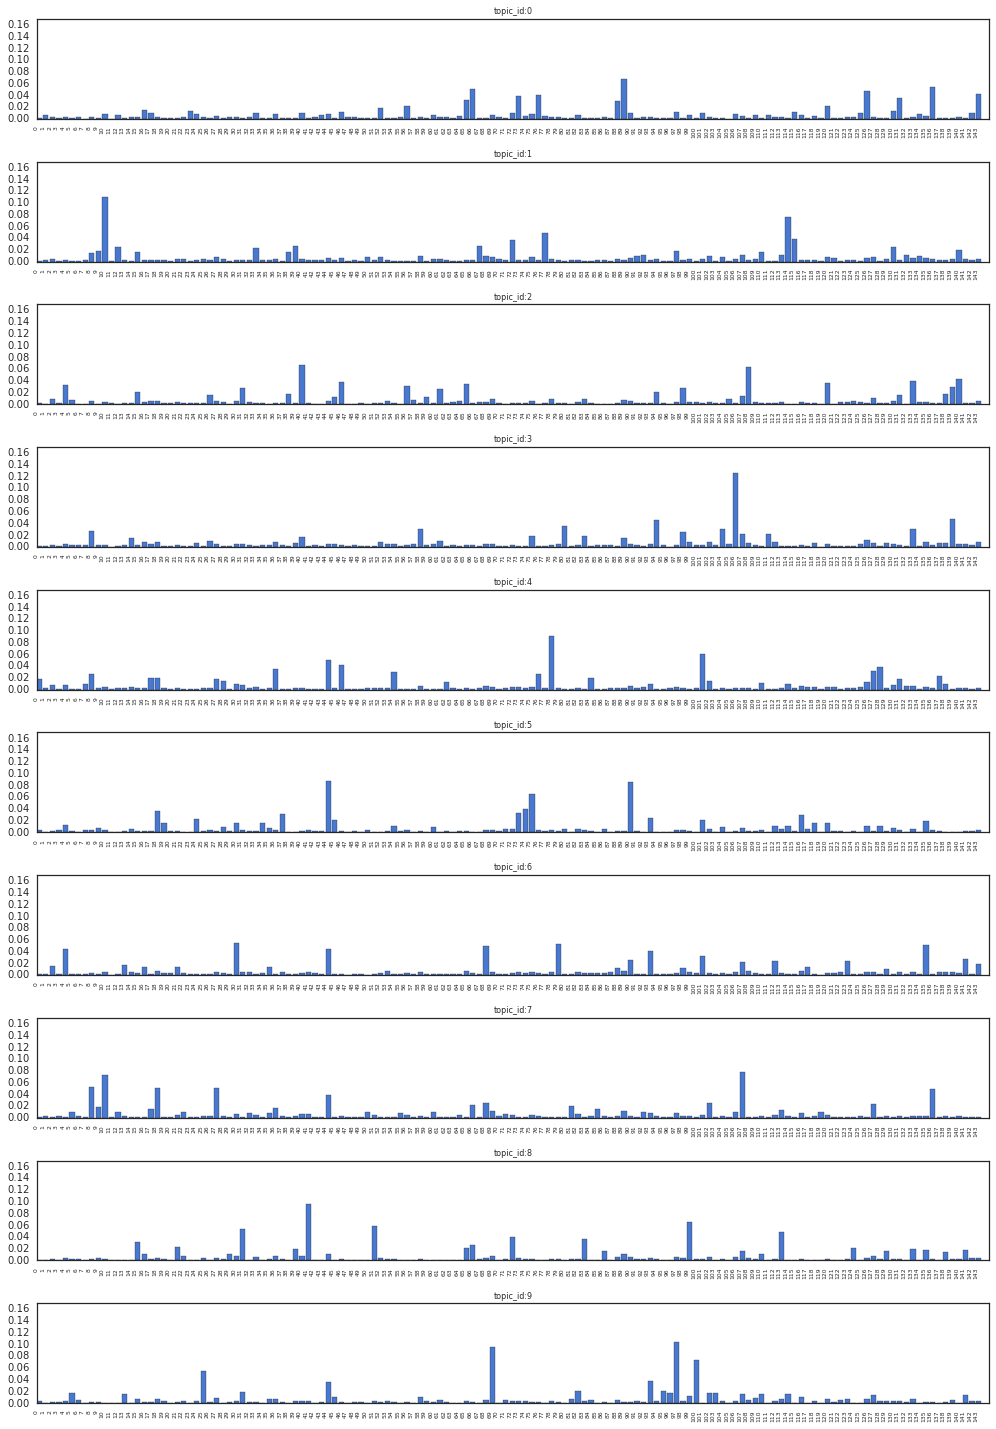

In [20]:
# word distribution(estimated)
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,20))
for i in range(K):
    plt.subplot(10,1,i+1)
    plt.bar(range(V), EAP_phi[:,i])
    plt.xticks(range(V), size=6, rotation='vertical')
    plt.yticks()
    plt.title("topic_id:{}".format(i), size=8)
    plt.xlim(0, 145)
    plt.ylim(0, .17)

plt.tight_layout()
plt.savefig("word_dist_EAP.png")

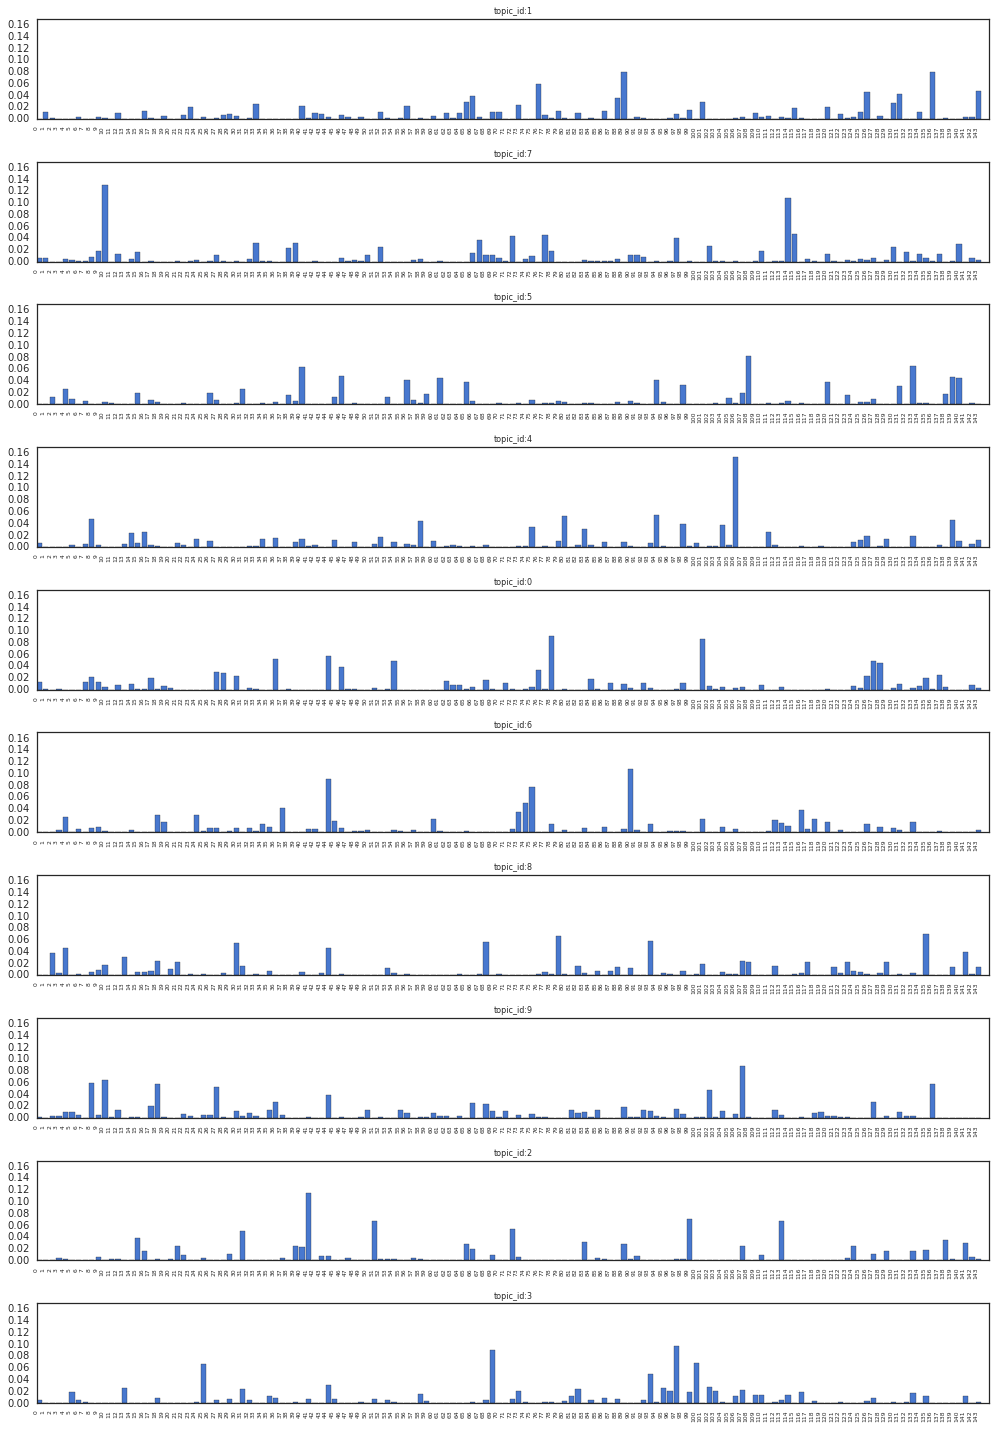

In [17]:
# word distribution(parameter)
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,20))
for i, topic in enumerate(param_order):
    plt.subplot(10,1,i+1)
    plt.bar(range(V), phi[topic,:])
    plt.xticks(range(V), size=6, rotation='vertical')
    plt.yticks()
    plt.title("topic_id:{}".format(topic), size=8)
    plt.xlim(0, 145)
    plt.ylim(0, .17)

plt.tight_layout()    
plt.savefig("word_dist.png")

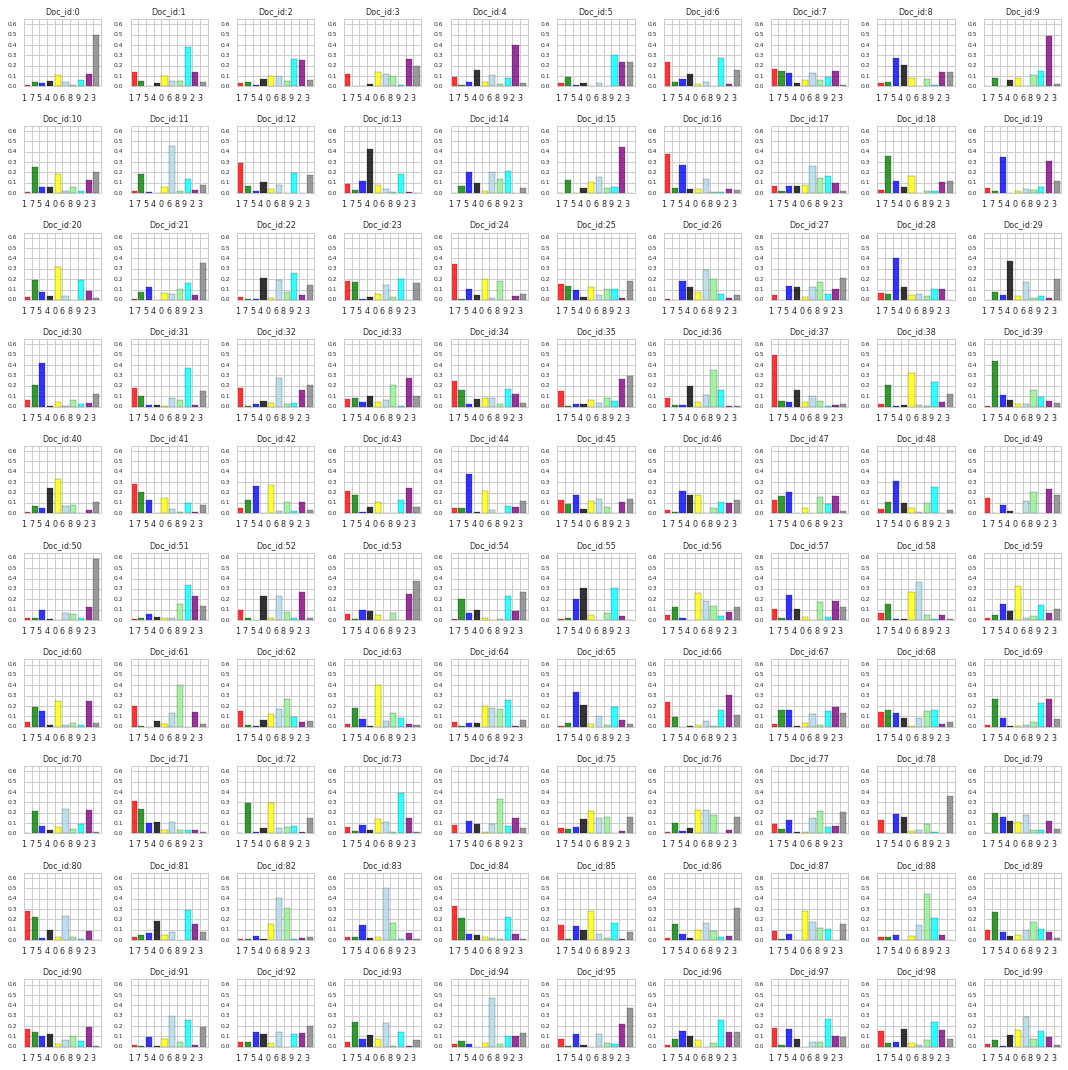

In [18]:
# parameter theta
sns.set(style="whitegrid", palette="muted", color_codes=True)
colors = "red,green,blue,black,yellow,lightblue,lightgreen,cyan,purple,gray".split(",")
plt.figure(figsize=(15,15))
plt.title("topic distribution(parameter)")
for i, t in enumerate(theta):
    #print t
    plt.subplot(K,K,i+1)
    plt.bar(range(K), t[param_order], color=colors, alpha=.8)
    plt.xticks(range(K), param_order, size=8)
    plt.yticks(size=6)
    plt.ylim(0, 0.65)
    plt.title("Doc_id:{}".format(i), size=8)

plt.tight_layout()    
plt.savefig("topic_dist.png")

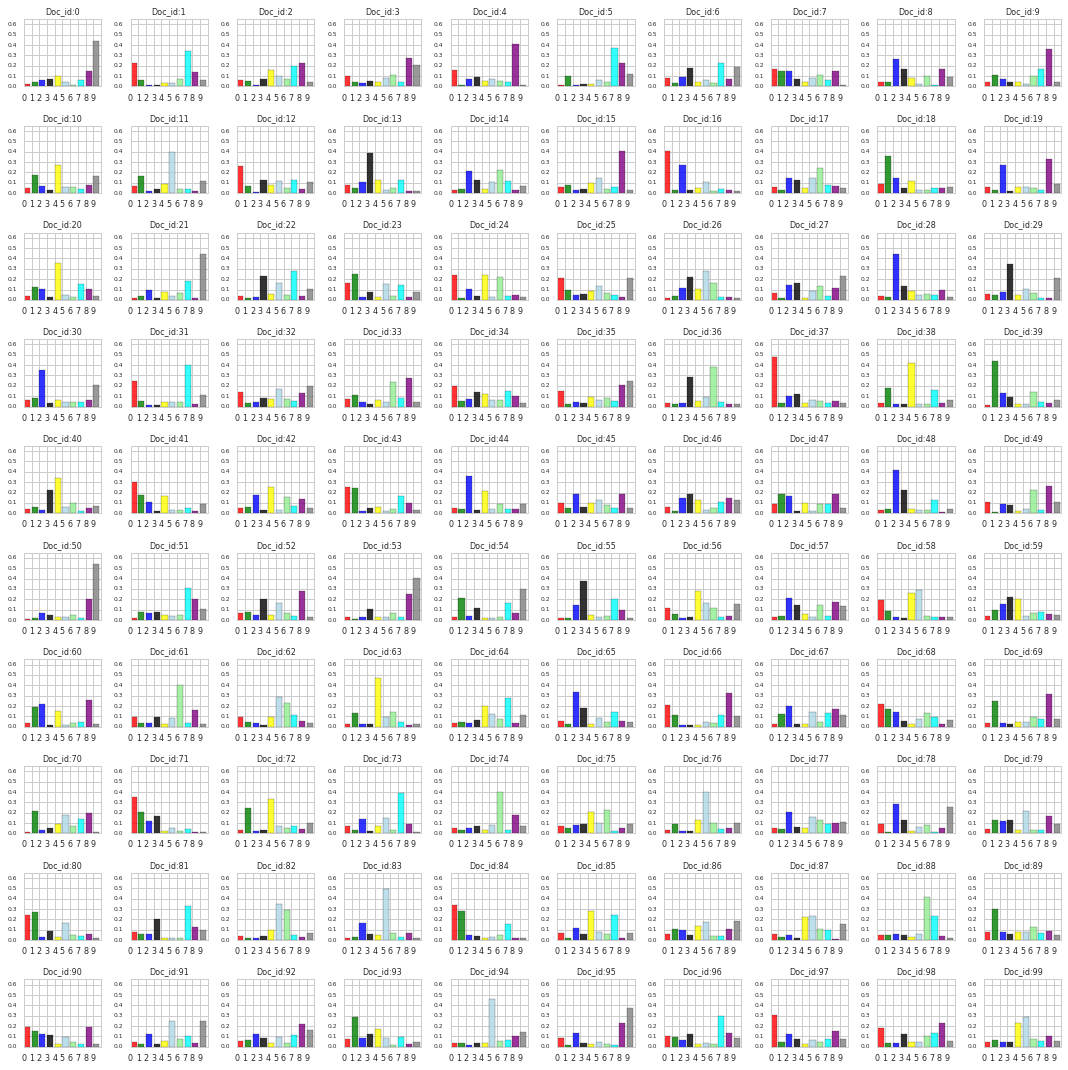

In [19]:
# topic distribution(estimated)
sns.set(style="whitegrid", palette="muted", color_codes=True)
colors = "red,green,blue,black,yellow,lightblue,lightgreen,cyan,purple,gray".split(",")
plt.figure(figsize=(15,15))
plt.title("topic distribution(EAP)")
for doc in range(M):
    plt.subplot(K,K,doc+1)
    #target = np.sort(EAP_theta[:,doc])
    plt.bar(range(K), EAP_theta[:,doc], color=colors, alpha=.8)
    plt.xticks(range(K), size=8)
    plt.yticks(size=6)
    plt.ylim(0, 0.65)
    plt.title("Doc_id:{}".format(doc), size=8)

plt.tight_layout()   
plt.savefig("topic_dist_EAP.png")

### Trace Plot

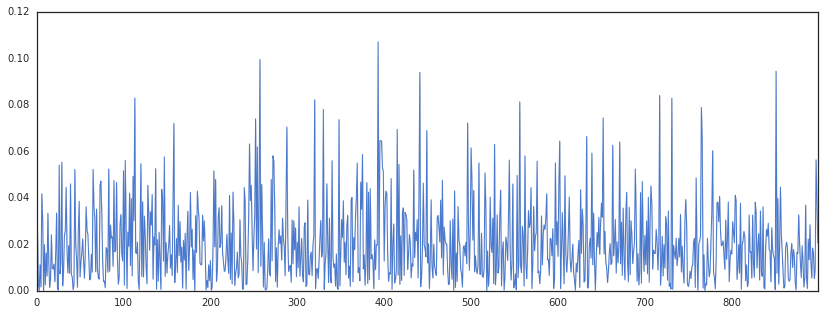

In [22]:
plt.figure(figsize=(14,5))
ax = plt.subplot()
sns.tsplot(la['theta'][:,0,0], lw=1, ax=ax)

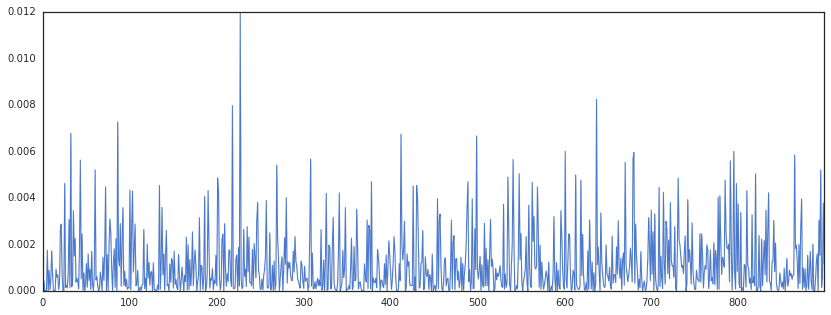

In [23]:
plt.figure(figsize=(14,5))
ax = plt.subplot()
sns.tsplot(la['phi'][:,0,0], lw=1, ax=ax)

### 分布の可視化

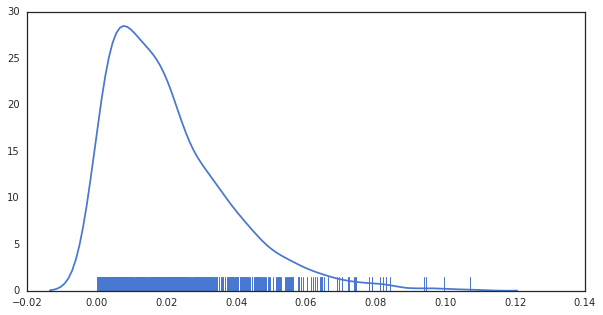

In [24]:
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.distplot(la['theta'][:,0,0], hist=False, rug=True, ax=ax)

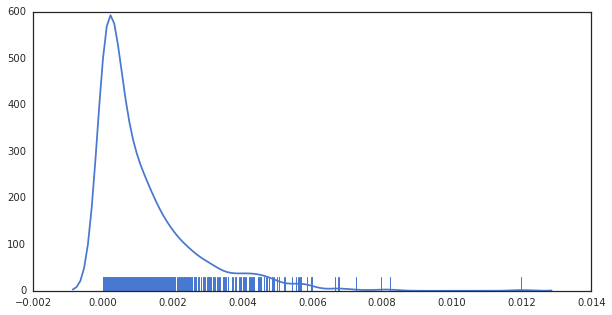

In [25]:
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.distplot(la['phi'][:,0,0], hist=False, rug=True, ax=ax)